In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import os
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


def initialization(seed=42):
    keras.backend.clear_session()
    np.random.seed(seed)
    tf.random.set_seed(seed)

# 使用Character RNN生成莎士比亚风格的文本

## 创建训练数据集 Creating the Training Dataset

1. 使用`Keras`的`get_file()`函数，从项目中下载所有莎士比亚的作品

In [2]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)

with open(filepath) as f:
    shakespeare_text = f.read()

1130496/1115394 [==============================] - 0s 0us/step


In [3]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [4]:
"".join(sorted(set(shakespeare_text.lower())))   # 显示文本中出现的所有字符

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

2. 将每个字符编码为一个整数。
    - 创建一个自定义预处理层，
    - 或使用`Keras`的`Tokenizer`会更加简单。
    
> **tf.keras.preprocessing.text.Tokenizer**
> ```python   
tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',  
    # filters过滤: 不包含 '
    lower=True,   # 是否转化为小写
    split=' ',
    char_level=False,   # true: 每个字符都将被视为一个标记
    oov_token=None,
    document_count=0,
    **kwargs
)
> ```   
> 
> 默认情况下，所有标点符号都被删除，将文本转换为空格分隔的单词序列（单词可能包括 ' 字符）。然后将这些序列拆分为标记列表。然后它们将被索引或矢量化。
0 是一个保留索引，不会分配给任何单词。
>
> `fit_on_texts(texts)` : 根据文本列表更新内部词汇表
>
> `fit_on_sequences(texts)` : 根据序列列表更新内部词汇表
>
> `get_config()` : 根据文本列表更新内部词汇表

- 首先，将一个将`tokenizer`拟合到文本：`tokenizer`能从文本中发现所有的字符，并将所有字符映射到不同的字符ID，**映射从1开始**.
- 设置`char_level=True`，以得到**字符级别的编码**，而不是默认的单词级别的编码。这个`tokenizer`默认**将所有文本转换成了小写**（如果不想这样，可以设置`lower=False`）

In [5]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

- 现在`tokenizer`可以将一整句（或句子列表）编码为`字符ID列表`，这可以告诉我们文本中有多少个独立的字符，以及总字符数.

In [6]:
tokenizer.texts_to_sequences(['First'])

[[20, 6, 9, 8, 3]]

In [7]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])   # 不区分大小写

['f i r s t']

In [8]:
# 列出字符索引
tokenizer.word_index

{' ': 1,
 'e': 2,
 't': 3,
 'o': 4,
 'a': 5,
 'i': 6,
 'h': 7,
 's': 8,
 'r': 9,
 'n': 10,
 '\n': 11,
 'l': 12,
 'd': 13,
 'u': 14,
 'm': 15,
 'y': 16,
 'w': 17,
 ',': 18,
 'c': 19,
 'f': 20,
 'g': 21,
 'b': 22,
 'p': 23,
 ':': 24,
 'k': 25,
 'v': 26,
 '.': 27,
 "'": 28,
 ';': 29,
 '?': 30,
 '!': 31,
 '-': 32,
 'j': 33,
 'q': 34,
 'x': 35,
 'z': 36,
 '3': 37,
 '&': 38,
 '$': 39}

In [9]:
# 字符索引数
max_id = len(tokenizer.word_index)
max_id

39

In [10]:
# 总字符数
dataset_size = tokenizer.document_count
dataset_size

1115394

- 现在对完整文本做编码，将每个字符都用ID来表示（减1**使ID从0到38**，而不是1到39）

In [11]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) -1
encoded  

array([19,  5,  8, ..., 20, 26, 10])

## 如何区分序列数据集 How to Split a Sequential Dataset

避免训练集、验证集、测试集发生重合非常重要。

当处理时间序列时，
- 通常按照时间切分,
- 也可以按照其它维度来切分，可以得到更长的时间周期进行训练。如果训练集中的数据存在高度关联性, 则测试集的意义就不大，泛化误差会存在偏移。

在莎士比亚案例中, 可以取90%的文本作为训练集，5%作为验证集，5%作为测试集。在这三个数据之间留出空隙，以避免段落重叠也是非常好的主意。

创建`tf.data.Dataset`, 可以从数据集中一个个返回字符.

In [12]:
train_size = dataset_size * 90 // 100     # train_size=1003854
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

2022-04-13 11:42:11.034727: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 11:42:11.159930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 11:42:11.161103: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-13 11:42:11.165383: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 使用Char-RNN模型 Using the Char-RNN model

- 首先需要对数据进行预处理
    
    对文本进行编码，将每个字符都用ID来表示(从0开始), 并使用独热编码.

In [13]:
def preprocess(tests):
    X = np.array(tokenizer.texts_to_sequences(tests)) - 1
    return tf.one_hot(X, max_id)

## 有状态RNN  Stateful RNN

### 原理及数据集划分

在Keras调用`LSTM/GRU`的参数中，有一个`stateful`参数，默认是`False`，也就是`无状态模式stateless`，为`True`的话就是`有状态模式stateful`.

>- `stateless LSTM`
>  
>  `stateless`就是与`stateful`相反了，就是sample之间没有前后状态传递的关系，输入samples后，默认就会shuffle，可以说是**每个sample独立**，适合输入一些没有关系的样本。

> - `stateful LSTM`
>    
>    除了正常的单个sample内部时间步之间的状态互相传递外，sample之间的状态还能互相传递。但是需要确定`batch_size`大小，传递的时候是前一个`batch`的第$i$个sample最终输出状态，传递给后一个`batch`的第$i$个sample，作为其状态的初始化值。
>     
>         解放军第72集团军某旅500名抗洪子弟兵撤离安徽铜陵枞阳县，赶赴合肥庐江县继续抗洪。当地百姓冒着大雨追着驶出的车辆，递上自家的莲蓬、葡萄、熟鸡蛋等食物，送别子弟兵。
    第一句话为一个sample，第二句话为第二个sample，每个sample内部的word为一个时间步，很明显前后两个sample是相互关联的。**如果设置`batch_size=1`,则第一句话最终输出状态(即最后一个word的状态输出)，就可以传递给第二句话作为其初始状态值**。
>    
>   - 优点：后面的语句有了更合理的初始化状态值，显然会加快网络的收敛，所以需要更小的网络、更少的训练时间。
>   - 缺点：每一个`epoch`后，要重置一下状态，因为训练一遍了，状态不能循环使用，要从头开始。
>   - 使用注意事项：**调用`fit()` 时指定 `shuffle = False`**，要保证sample之间的前后顺序；可以使用`model.reset_states()`来重置模型中所有层的状态，也可使用`layer.reset_states()`来重置指定有状态 RNN 层的状态。



> 参考: https://www.cnblogs.com/gczr/p/13393883.html

`stateful RNN`只在前一批次的序列离开，后一批次中的对应输入序列开始的情况下才有意义。

- 首先,**使用序列且没有重叠的输入序列**（而不是用来训练无状态RNN时的打散和重叠的序列）。
    - 当创建`Dataset`时，**调用`window()`必须使用`shift=n_steps`**（而不是`shift=1`）。
            例: window_size=31, shfit=30, 
                train_x=[1,...,31] (31-1=30), train_y=[2,...,31], 
                next, train_x=[31,...,61], train_y=[32...62],
    - 不能使用`shuffle()`方法。但是，准备`stateful RNN`数据集的批处理会麻烦些。事实上，如果调用`batch(32)`，32个连续的窗口会放到一个相同的批处理中，而下一个批处理不会再这些窗口的每个中断处继续。第一个批次含有窗口1到32，第二个批次批次含有窗口33到64，因此每个批次中的第一个窗口（第一批次的窗口1和第二批次的窗口33），它们是不连续的。
  
  
- 最简单办法是**使用只包含单个窗口的"批处理"**：
   <img src="./images/other/15-23.png" width="500">

In [14]:
initialization(42)

n_steps = 100 
window_length = n_steps + 1  

- 使用以下方法也可以**实现批处理**
   - 将莎士比亚作品切分成32段等长的文本
   - 每个文本创建一个连续输入的数据集
   - 最后使用`tf.train.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))`来创建合适的连续批处理，其中批处理中的第$n$个输入序列恰好是上一个批处理中第$n$个输入序列结束位置的开始.

In [15]:
batch_size = 32
encoded_parts = np.array_split(ary=encoded[:train_size],
                               indices_or_sections=batch_size)
# 划分为32段等长的文本
# 每段31371个字符, 最后一段为31370

In [16]:
datasets = []

for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(size=window_length,
                             shift=n_steps,
                             drop_remainder=True)
    dataset = dataset.flat_map(lambda window:window.batch(window_length))
    datasets.append(dataset)

    encoded_part_size=31371
    迭代次数: ( len(text)-window_size ) // shift +1 
           = ( 31371 - 101 ) // 100 + 1 = 313
    即: 共有313个窗口, 每个窗口大小为101

In [17]:
dataset = tf.data.Dataset.zip(
    tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset

<MapDataset shapes: (32, None), types: tf.int64>

In [18]:
dataset = dataset.map(lambda window: (window[:, :-1], window[:, 1:]))
dataset = dataset.map(lambda X_batch, y_batch:
                      (tf.one_hot(X_batch, max_id), y_batch))
dataset = dataset.prefetch(1)

In [19]:
for X_batch, y_batch in dataset.take(1): 
    print(X_batch.shape, y_batch.shape) 

2022-04-13 11:42:16.208058: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(32, 100, 39) (32, 100)


### 搭建并训练模型

1. 搭建`stateful RNN`模型
    - 创建每个循环层时需要**设置`stateful=True`**
    - 有状态RNN需要知道批次大小（因为要为批次中的每个输入序列保留一个状态），所以要必须在第一层中设置`batch_input_shape`。
        - 注意:可以不用指定第二个维度，因为输入可以有任意长度.

In [20]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]),
    keras.layers.GRU(128, return_sequences=True, stateful=True,
                     dropout=0.2,),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

2. 在每个`epoch`之后, 需要先重设状态, 然后再返回到文本的开头。因此, 我们需要使用回调函数.

In [21]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [22]:
EarlyStoppingCallback = keras.callbacks.EarlyStopping(patience=10,  # 至多10个轮次
                                                      restore_best_weights=True)

3. 编译并训练模型

In [23]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=100,
                    callbacks=[ResetStatesCallback(), EarlyStoppingCallback])

Epoch 1/100


2022-04-13 11:42:22.105494: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


313/313 [==============================] - 11s 19ms/step - loss: 2.6204
Epoch 2/100
313/313 [==============================] - 7s 21ms/step - loss: 2.2427
Epoch 3/100
313/313 [==============================] - 6s 18ms/step - loss: 2.1129
Epoch 4/100
313/313 [==============================] - 6s 20ms/step - loss: 2.0384
Epoch 5/100
313/313 [==============================] - 6s 20ms/step - loss: 1.9869
Epoch 6/100
313/313 [==============================] - 6s 19ms/step - loss: 1.9511
Epoch 7/100
313/313 [==============================] - 6s 20ms/step - loss: 1.9225
Epoch 8/100
313/313 [==============================] - 6s 19ms/step - loss: 1.8983
Epoch 9/100
313/313 [==============================] - 6s 19ms/step - loss: 1.8815
Epoch 10/100
313/313 [==============================] - 6s 20ms/step - loss: 1.8663
Epoch 11/100
313/313 [==============================] - 6s 20ms/step - loss: 1.8505
Epoch 12/100
313/313 [==============================] - 6s 19ms/step - loss: 1.8422
Epoch 13/100

In [24]:
model.save("./models/my_stateful_RNN.h5")

In [25]:
model = keras.models.load_model('./models/my_stateful_RNN.h5')

In [26]:
history_dict = history.history
train_loss = history_dict["loss"]

Text(0, 0.5, 'loss')

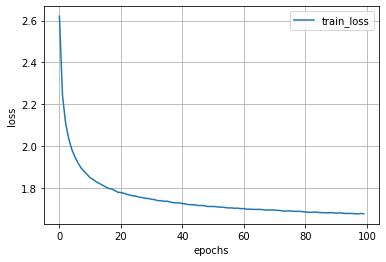

In [27]:
epochs = 100
# figure 1
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.legend()
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('loss')